In [1]:
from IPython.display import HTML
toggle_text = '''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>'''


# Predicting Graduation Rates at 4 Year Universities

## <ul><li>My First Data Science Portfolio Project</li></ul>

In [53]:
import cbell as cb

In [3]:
import pandas as pd
import numpy as np

#conda install -c conda-forge cufflinks-py
#conda install plotly
import ipywidgets as wg
from IPython.display import display
import pandas as pd 
import numpy as np
import cufflinks as cf
import chart_studio.plotly as py

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

%matplotlib inline
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import inspect
import seaborn as sns
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
pd.options.display.max_columns = 200
pd.options.display.max_rows = 272

from joblib import dump, load
from Logger import RegressionLogger, FuncTransformer, ColSelect

In [4]:
df = pd.read_csv("data/cleaned_df.csv", index_col="UnitID")
df.drop("Unnamed: 0",axis=1, inplace=True)
df.drop(["City location of institution (HD2019)", "Institution Name"], axis=1, inplace=True)
X = df.iloc[:, :-14]
y = df.iloc[:,-14]
X = pd.get_dummies(X, drop_first=True)

In [5]:
model_log = load("data/model_logging.joblib")

In [6]:
df = pd.read_csv("data/cleaned_df.csv", index_col="UnitID")

In [7]:
df.filter(regex='Grad').describe().loc['mean'].sort_values().index

Index(['Graduation rate  Black  non-Hispanic (DRVGR2019)',
       'Graduation rate  American Indian or Alaska Native (DRVGR2019)',
       'Graduation rate  Hispanic (DRVGR2019)',
       'Graduation rate  men (DRVGR2019)',
       'Graduation rate  two or more races (DRVGR2019)',
       'Graduation rate  Native Hawaiian or Other Pacific Islander (DRVGR2019)',
       'Graduation rate  Race/ethnicity unknown (DRVGR2019)',
       'Graduation rate  total cohort (DRVGR2019)',
       'Graduation rate  White  non-Hispanic (DRVGR2019)',
       'Graduation rate  women (DRVGR2019)',
       'Graduation rate  Asian/Native Hawaiian/Other Pacific Islander (DRVGR2019)',
       'Graduation rate  Nonresident alien (DRVGR2019)',
       'Graduation rate  Asian (DRVGR2019)'],
      dtype='object')

In [8]:
means = df.filter(regex='Grad').describe().loc['mean'].sort_values().to_numpy()
cols = ['Black', 'American Indian', 'Hispanic', 'men', 'two or more races', 
        'Native Hawaiian', 'unknown', 'total cohort', 'White',
        'women', 'Asian/Native Hawaiian', 'Nonresident alien', 'Asian']
#cols = cols.str.replace("Graduation rate", "")
#cols = cols.str.replace("DRVGR2019", "")
#cols = cols.str.replace("Other Pacific Islander", "")
mean_fig = go.Figure()
_ = mean_fig.add_trace(go.Bar(
    x=cols, y=means, text=np.round(means, 2)
))
_ = mean_fig.update_layout(
    title='Mean Graudation Rates',
    xaxis={
        'title': "Gender/Race"
    },
    yaxis = {
        'title': "Mean Graduation Rate"
    },
    height = 600
)

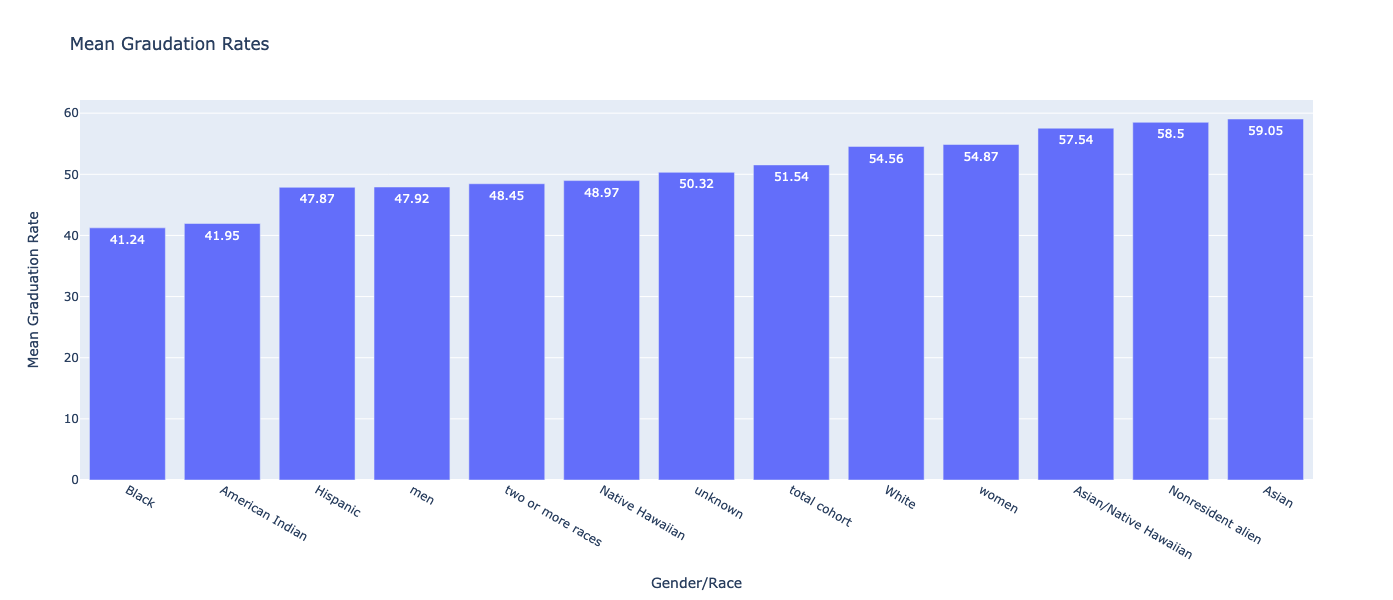

In [9]:
mean_fig.show()

### <ul><li>4 year institutions</li></ul>

### <ul><li>2019 Cohort</li></ul>

### <ul><li>6 year Graduation Rates</li></ul>

# Problem Statement

## <ul><li>Problem</li></ul>
University X is facing pressure from the community claiming that the university is underperforming particularly with students of color. The University needs to respond to the community with a data backed explanation for their performance along with a data driven plan to improve outcome measures (Graduation Rates)


## <ul><li>Available Data</li></ul>

The Data Science team has access to the free publicly available Ipeds Data Center, which has data about all 4-year public and private institutions.

<a src='https://nces.ed.gov/ipeds/use-the-data'>Ipeds Data Center</a>

In [10]:
# Reset Our Data Frame
df = pd.read_csv("data/cleaned_df.csv", index_col="UnitID")
df.drop("Unnamed: 0",axis=1, inplace=True)

# Overview Of Features

## Numeric Features
<ul>
    <li>Revenues and Expenses</li>
    <li>Price of School</li>
    <li>Admissions Test Scores</li>
    <li>Staff Diversity</li>
    <li>Enrollment Diversity</li>
</ul>

## Categorical Features
<ul>
    <li>State</li>
    <li>Sector</li>
    <li>Carnegie Classification</li>
    <li>HBCU</li>
</ul>

# Sector

In [ ]:
sector = df.filter(regex="Sector").columns[0]
black = df.filter(regex="Grad.*Black").columns[0]
total = df.filter(regex="Grad").columns[0]

In [ ]:
all_sectors = df[sector].unique()

In [ ]:
sector_group = df.groupby(by=sector)

In [ ]:
grad_rate_by_sector = sector_group.agg('mean').sort_values(by=black)[[black, total]]

In [ ]:
grad_rate_by_sector.drop(['Public, 2-year', 'isMissing', 'Private not-for-profit, 2-year', 
                          'Private for-profit, 2-year', 'Private for-profit, less-than 2-year'],
                         inplace=True)

In [ ]:
all_sectors[1]

In [ ]:
not_for_profit = sector_group.get_group(all_sectors[2])[black].dropna().to_numpy()
bootstrap_sample = np.array(cb.bs_replicate(not_for_profit, np.mean, 10000))
ci = np.round(np.percentile(bootstrap_sample, [2.5, 97.5]), 2)
sector_error1 = (ci[1] - ci[0]) / 2

In [ ]:
public_4black = sector_group.get_group(all_sectors[2])[black].dropna().to_numpy()
bootstrap_sample = np.array(cb.bs_replicate(public_4black, np.mean, 10000))
ci = np.round(np.percentile(bootstrap_sample, [2.5, 97.5]), 2)
sector_error2 = (ci[1] - ci[0]) / 2

In [ ]:
private_for_profit = sector_group.get_group(all_sectors[3])[black].dropna().to_numpy()
bootstrap_sample = np.array(cb.bs_replicate(private_for_profit, np.mean, 10000))
ci = np.round(np.percentile(bootstrap_sample, [2.5, 97.5]), 2)
sector_error3 = (ci[1] - ci[0]) / 2

In [ ]:
sector_fig = go.Figure(
    data = [
        go.Bar(x=grad_rate_by_sector.index, y=grad_rate_by_sector[black], 
               text=np.round(grad_rate_by_sector[black], 1), name="African American",
               error_y=dict(type='data', array=[sector_error1, sector_error2, sector_error3])),
        
        go.Bar(x=grad_rate_by_sector.index, y=grad_rate_by_sector[total], 
               text=np.round(grad_rate_by_sector[total], 1), name="Total Cohort"),
        
    ]
)

_ = sector_fig.update_layout(
    title="Mean Graduation Rates By Sector of Institution",
    xaxis={
        'title': "Sector"
    },
    yaxis={
        'title': 'Mean Graduation Rate'
    }
)

In [ ]:
sector_fig.show()

# Graduation Rates by State

In [ ]:
state = df.filter(regex="State").columns[0]
all_states = df[state].unique()

In [ ]:
state_group = df.groupby(by=state)

In [24]:
grad_rate_by_state = state_group.agg('mean').sort_values(by=black)[[black, total]].dropna()

In [25]:
state_yblack = grad_rate_by_state[black].to_numpy()[0:51:10]
state_y = grad_rate_by_state[total].to_numpy()[0:51:10]

state_fig = go.Figure(
    data = [
        go.Bar(x=grad_rate_by_state.index[0:51:10], y= state_yblack, 
               text=np.round(state_yblack, 1), name="African American"),
        go.Bar(x=grad_rate_by_state.index[0:51:10], y=state_y, 
               text=np.round(state_y, 1), name="Total Cohort")
    ]
)

_ = state_fig.update_layout(
    title="Mean Graduation Rates By State",
    xaxis={
        'title': "State"
    },
    yaxis={
        'title': 'Mean Graduation Rate'
    }
)

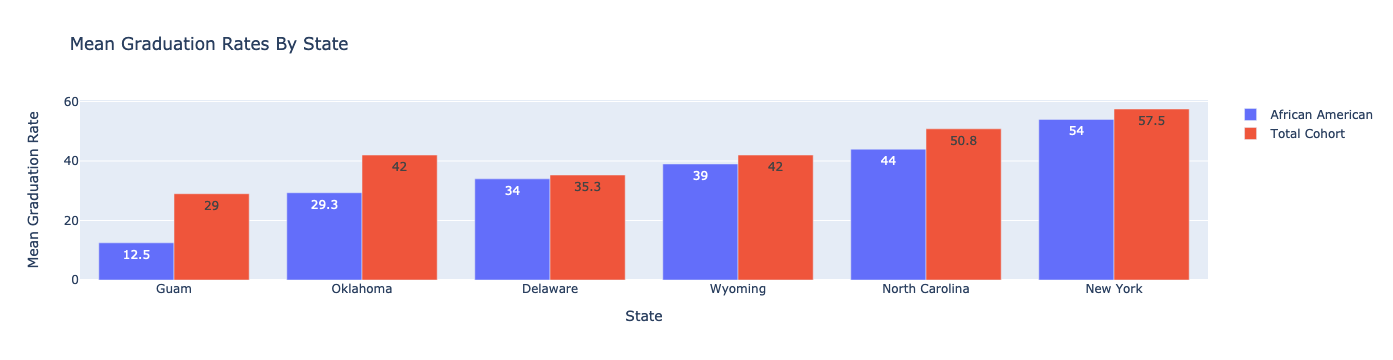

In [26]:
state_fig.show()

# Graduation Rates (HBCU vs Non HBCU)

In [27]:
hbcu = df.filter(regex="Historically").columns[0]
hbcu_group = df.groupby(by=hbcu)
grad_rate_hbcu = hbcu_group.agg('mean').sort_values(by=black)[[black, total]]

In [28]:
grad_rate_hbcu = grad_rate_hbcu.drop("isMissing")

In [29]:
hbcu_fig = go.Figure(
    data = [
        go.Bar(x=grad_rate_hbcu.index, y=grad_rate_hbcu[black], 
               text=np.round(grad_rate_hbcu[black], 1), name="African American"),
        go.Bar(x=grad_rate_hbcu.index, y=grad_rate_hbcu[total], 
               text=np.round(grad_rate_hbcu[total], 1), name="Total Cohort")
    ]
)

_ = hbcu_fig.update_layout(
    title="Mean Graduation Rates For Historically Black Colleges and Universities",
    xaxis={
        'title': "Is_HBCU"
    },
    yaxis={
        'title': 'Mean Graduation Rate'
    },
    width=500
)

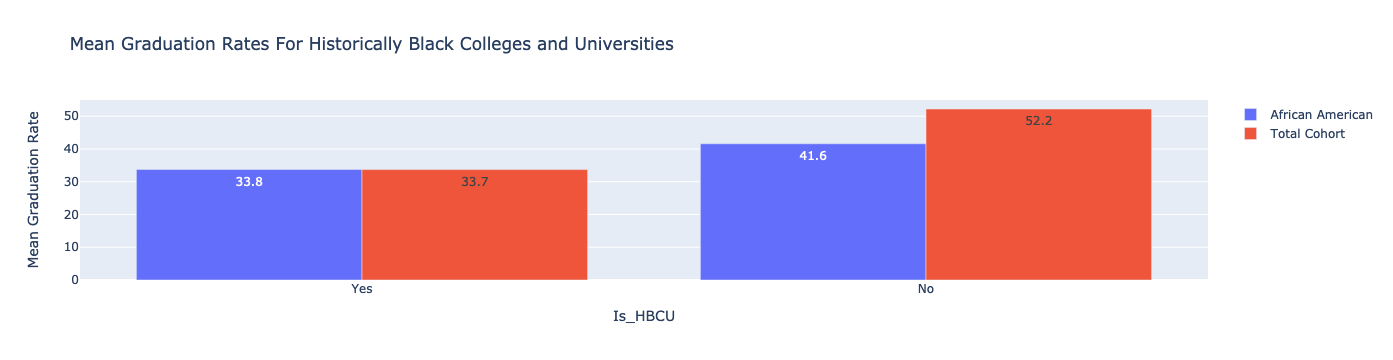

In [30]:
hbcu_fig.show()

# Whats The Problem With These Comparisons?

# Model Performance Total Graduation Rate

In [31]:
# load in feature engineered features
X_fe = load("data/features.joblib")

In [32]:
model = model_log[4]['model']

In [33]:
pd.DataFrame(model_log[4], index=[0])

,Imputer,model_name,model,alpha,l1_ratio,rsquared,rmse,mae,train_rsquared,train_rmse,train_mae,notes
0,KNNImputer,Elastic Net,"(FeatureUnion(transformer_list=[('numeric',\n ...",0.3,0.8,0.536707,14.015952,9.509088,0.634621,13.306718,9.332271,Tuned Elstic Net Model


In [34]:
model_log = load("data/model_logging.joblib")

In [35]:
params = {}
logger = RegressionLogger(params)
logger.train_update(model, X_fe, y)

# Residual Plots

In [56]:
residuals = logger.y_pred - logger.y_test
resid_data = {
    'y_test': logger.y_test,
    'Residuals':residuals,
}

resid_fig = px.scatter(resid_data, x='y_test', y='Residuals')
_ = resid_fig.update_layout(title='Residuals vs Observed Graduation Rates')

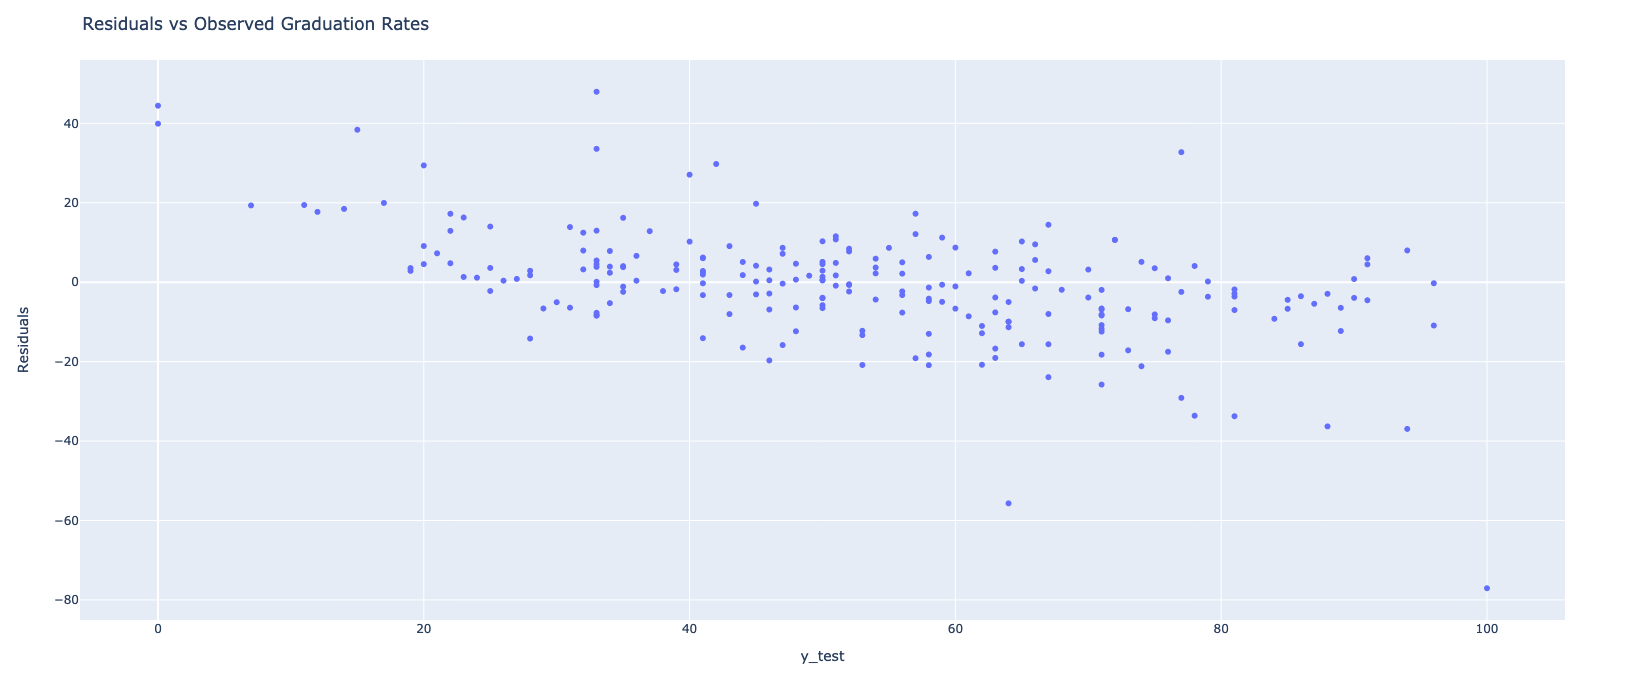

In [55]:
resid_fig.show()

In [38]:
residuals = logger.y_pred - logger.y_test
resid_data = {
    'y_pred': logger.y_pred,
    'Residuals':residuals,
}
pred_fig = px.scatter(resid_data, x='y_pred', y='Residuals')
_ = pred_fig.update_layout(title='Residuals vs Predicted Graduation Rates')

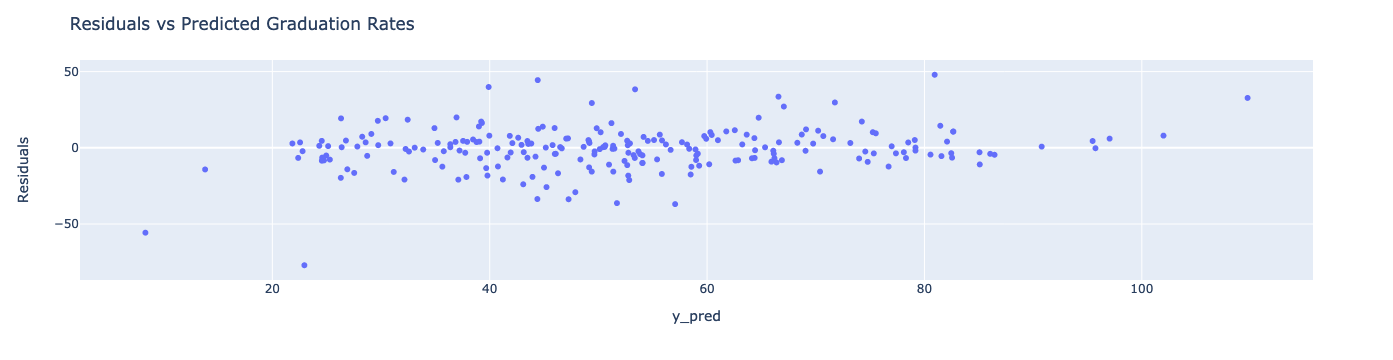

In [39]:
pred_fig.show()

# Model Coefficients

In [40]:
coefs = model['classifier'].coef_
feature_names = load("data/feature_names.joblib")
final_coefs = sorted(list(zip(feature_names, coefs)), key= lambda x: np.abs(x[1]))
coef_dict = {k: v for k, v in sorted(dict(zip(feature_names, coefs)).items(), key= lambda x: x[1])}

In [41]:
best = final_coefs[-11:]
best = sorted(best, key=lambda x: x[1])

In [42]:
coefs_fig = make_subplots(rows=1, cols=1, subplot_titles=["Model Coeficients"])

_ = coefs_fig.add_trace(
    go.Bar(x=[i[1] for i in best], y=[i[0] for i in best], 
           orientation='h', text=[round(i[1], 2) for i in best]),
    1, 1)

_ = coefs_fig.update_yaxes(
    tickangle = 10
)

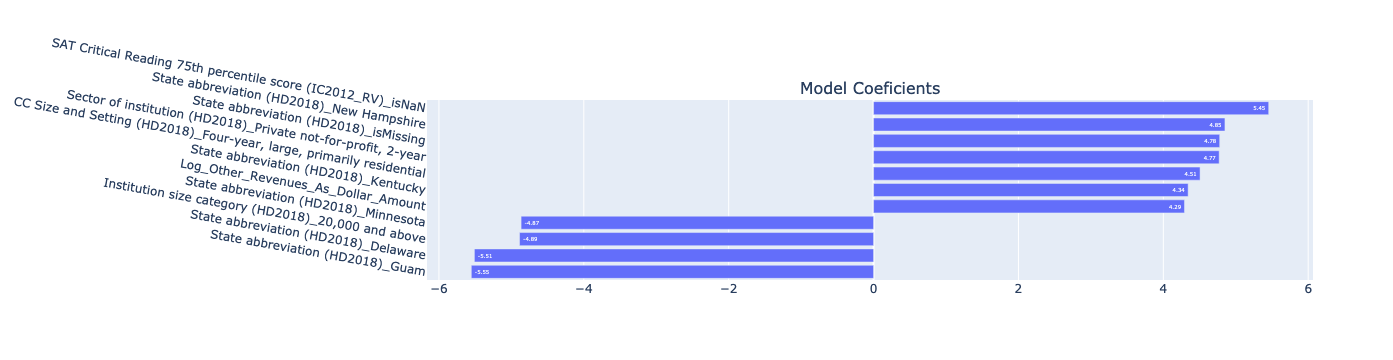

In [43]:
coefs_fig.show()

# Interpreting Coefficients With Numbers

## Using inverse transform: a one init Increase in log revenues is 18.100074082796795 

## Therefore a 72,570,864.4257857 increase in other revenues will increase the projected graduation rates for school X to increase by 4.29%

In [44]:
# Getting Coefficient Interpretation
preprocess = model['preprocessing'].transformer_list[0][1] # Getting float preprocessing steps

# preprocess features the with the same steps as our pipeline
data = preprocess.fit_transform(X_fe)

# Set Log_Other_Revenues to 1 Unit
transformed_df = pd.DataFrame(data, columns=X_fe.select_dtypes(include='float').columns)
transformed_df['Log_Other_Revenues_As_Dollar_Amount'] = 1

# Inverse transform the preprocessed data
inverse_data = preprocess['Scale'].inverse_transform(transformed_df)
inverse_df = pd.DataFrame(inverse_data, columns=X_fe.select_dtypes(include='float').columns)

In [45]:
# View what a one unit increase in log other revenues realy means
new_line = '/n'
log_amount = inverse_df['Log_Other_Revenues_As_Dollar_Amount'].iloc[0]

f'A One Unit Increase in Log_Revenues is {log_amount}, therefore a {np.exp(log_amount)}'\
' increase in other revenues will increase the projected graduation rates for school X to increase' \
' by 4.29%'

'A One Unit Increase in Log_Revenues is 18.100074082796795, therefore a 72570864.4257857 increase in other revenues will increase the projected graduation rates for school X to increase by 4.29%'

# Model Performance African American Graduation Rate

# Another Look At HBCU vs Non HBCU

In [46]:
hbcu_df = df[df[hbcu] == 'Yes']
hwcu_df = df[df[hbcu] == 'No']
missing = df[df[hbcu] == 'isMissing']

In [47]:
hbcu_fig = px.scatter(
    df, x='Core_Revenues', y=total, color=hbcu, title="HBCU Graduation Rates vs Ccore Revenues",
    hover_name='Institution Name'
)

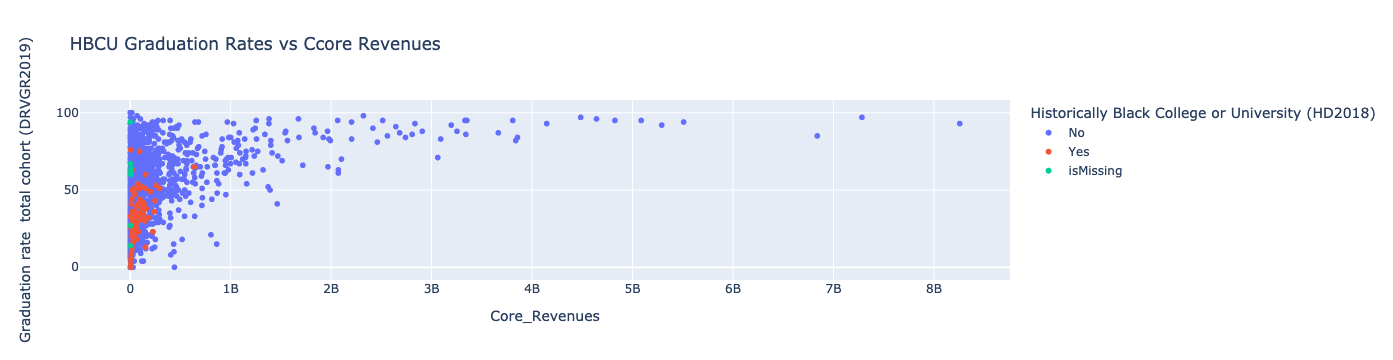

In [48]:
hbcu_fig.show()

In [49]:
price = df.filter(regex='price').columns[2]
test_score = df.filter(regex='Composite').columns[0]

# HBCU Graduation Rates By Price

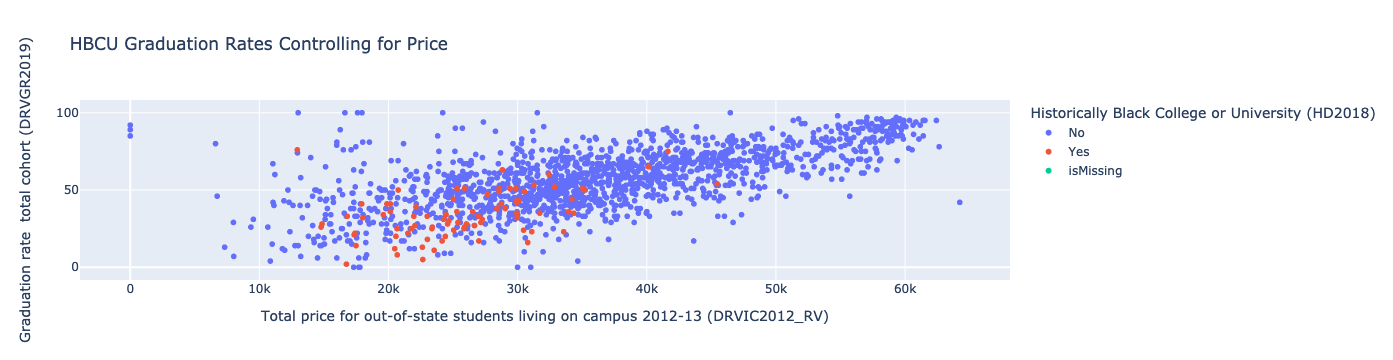

In [50]:
fig = px.scatter(
    df, x=price, y=total, color=hbcu, title="HBCU Graduation Rates Controlling for Price",
    hover_name='Institution Name'
)
fig.show()

# Controlling for Price and SAT Scores

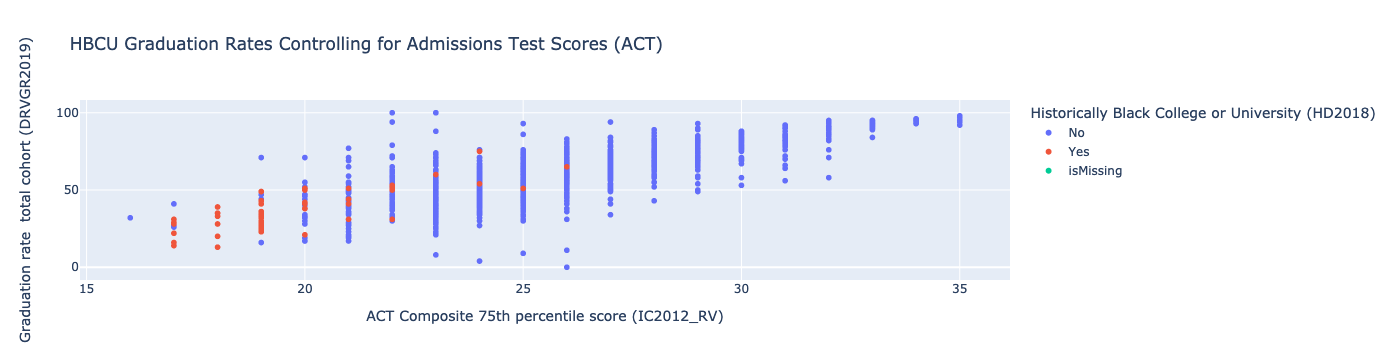

In [51]:
fig = px.scatter(
    df, x=test_score, y=total, color=hbcu, 
    title="HBCU Graduation Rates Controlling for Admissions Test Scores (ACT)",
    hover_name='Institution Name'
)
fig.show()

# Conclusion

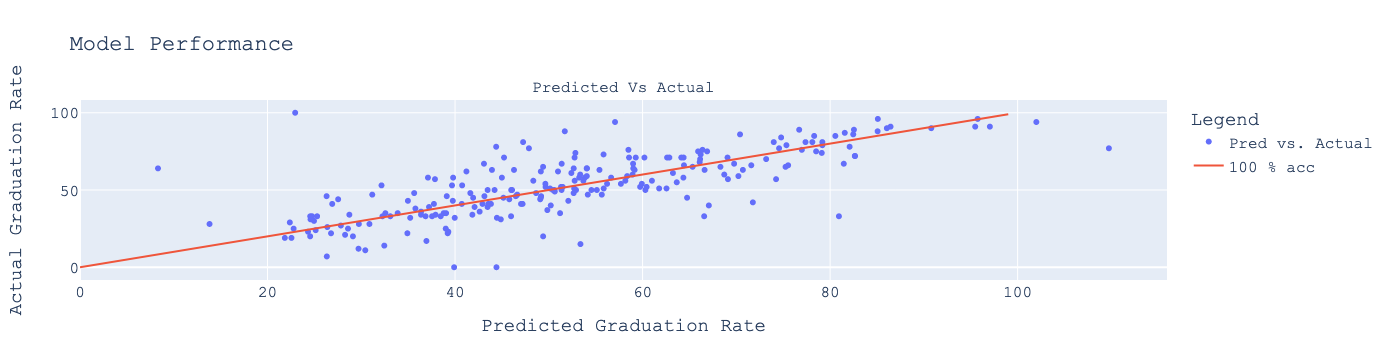

In [52]:
fig = make_subplots(rows=1, cols=1, subplot_titles=["Predicted Vs Actual"])

fig.add_trace(
    go.Scatter(x=logger.y_pred, y=logger.y_test, mode='markers', name='Pred vs. Actual'),
    1, 1)

fig.add_trace(
    go.Scatter(x=np.arange(0,100,1), y=np.arange(0,100,1), mode='lines', name='100 % acc')
)

fig.update_layout(
    title="Model Performance",
    xaxis_title="Predicted Graduation Rate",
    yaxis_title="Actual Graduation Rate",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=16,
    )
)

fig.show()